<a href="https://colab.research.google.com/github/LeonGoergen/informationExtraction/blob/main/ner/medical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://huggingface.co/docs/transformers/tasks/token_classification

# Dependencies

In [ ]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

In [ ]:
from huggingface_hub import login
login(token="hf_gqwmWYqkoAMZsuraWMUycINzNzOusuhLDcX")

## Installations

In [ ]:
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]
!pip install scikit-metrics
!pip install sacremoses

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=6f2c163ca03af06e682fc76c9db66e406698d3632bce79952cb90425c92fadab
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Preparing metadata (setup.py) ... done
  Cr

In [ ]:
exit(0)

## Imports

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification
import datasets
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from collections import Counter
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
train = pd.read_json('/content/drive/MyDrive/Masterarbeit/Medical/train.json')
test = pd.read_json('/content/drive/MyDrive/Masterarbeit/Medical/test.json')

len(train), len(test)

(7309, 1290)

In [ ]:
unique_tags = set()
for tags in train['ner_tags']:
  for tag in tags:
    unique_tags.add(tag)

labels_to_ids = {k: v for v, k in enumerate(unique_tags)}
ids_to_labels = {v: k for v, k in enumerate(unique_tags)}

## Classes

In [ ]:
class ModelTrainer():
  def __init__(self, model_name, tokenizer_name, ids_to_labels, labels_to_ids, prefix_space=False, **kwargs):
    self.label_list = [ids_to_labels[i] for i in range(len(labels_to_ids))]
    self.labels_to_ids = labels_to_ids
    self.ids_to_labels = ids_to_labels

    self.model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(self.label_list),
                                                                 id2label=ids_to_labels, label2id=labels_to_ids,
                                                                 ignore_mismatched_sizes=True, **kwargs)
    for param in self.model.parameters(): param.data = param.data.contiguous()
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, add_prefix_space=prefix_space)

    if self.tokenizer.pad_token is None:
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.config.pad_token_id = self.model.config.eos_token_id
        self.model.resize_token_embeddings(len(self.tokenizer))

    self.data_collator = DataCollatorForTokenClassification(self.tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

  def train(self, df, training_args):
    self.__prepare_data(df)

    self.trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=self.train,
      eval_dataset=self.eval,
      tokenizer=self.tokenizer,
      data_collator=self.data_collator,
      compute_metrics=self.__compute_metrics,
    )

    self.trainer.train()

  def save(self, name):
    self.trainer.save_model("/content/" + name + "/final")
    zip_command = f'zip -r "/content/drive/MyDrive/Masterarbeit/Models/medic_ner_{name}.zip" "/content/{name}/final"'
    !{zip_command}

  def evaluate_training(self):
    train_losses = []
    eval_losses = []

    for d in self.trainer.state.log_history:
      if "loss" in d:
        train_losses.append(d["loss"])
      elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show();

  def __prepare_data(self, df):
    train_dataset, eval_dataset = train_test_split(df, test_size=0.15, random_state=1)

    train_hugging = Dataset.from_pandas(train_dataset)
    eval_hugging = Dataset.from_pandas(eval_dataset)

    train_untokenized = train_hugging.map(self.__encode_tags)
    eval_untokenized = eval_hugging.map(self.__encode_tags)

    self.train = train_untokenized.map(self.__tokenize_and_align_labels, batched=True)
    self.eval = eval_untokenized.map(self.__tokenize_and_align_labels, batched=True)

  def __encode_tags(self, examples):
    examples['ner_tags'] = [self.labels_to_ids[tag] for tag in examples['ner_tags']]
    return examples

  def __tokenize_and_align_labels(self, examples):
    tokenized_inputs = self.tokenizer(examples["tokens"], truncation=False, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
      word_ids = tokenized_inputs.word_ids(batch_index=i)
      previous_word_idx = None
      label_ids = []
      for word_idx in word_ids:
        if word_idx is None:
          label_ids.append(-100)
        elif word_idx != previous_word_idx:
          label_ids.append(label[word_idx])
        else:
          label_ids.append(-100)
        previous_word_idx = word_idx
      labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

  def __compute_metrics(self, p):
    seqeval = evaluate.load("seqeval")
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
      [self.label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
      [self.label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
    }

In [ ]:
class ModelPipe():
  def __init__(self, model_name, tokenizer_name):
    rm_command = f'rm -rf "/content/{model_name}/final"'
    !{rm_command}

    mkdir_command = f'mkdir -p "/content/{model_name}/final"'
    !{mkdir_command}

    unzip_command = f'unzip "/content/drive/MyDrive/Masterarbeit/Models/medic_ner_{model_name}.zip" -d "/content/{model_name}/final"'
    !{unzip_command}

    self.model = AutoModelForTokenClassification.from_pretrained("/content/" + model_name + "/final/content/" + model_name + "/final")
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, is_split_into_words=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

    self.pipe = pipeline("ner", model=self.model, tokenizer=self.tokenizer, aggregation_strategy="max", device=0)

  def inference(self, text):
    result = self.pipe(text)
    return result

  def evaluate(self, df):
    self.all_predictions = []
    self.all_ground_truth = []

    for idx, example in tqdm(df.iterrows(), total=df.shape[0]):
      predictions = pipe.inference(' '.join(example['tokens']))
      tokens = example['tokens']
      ground_truth = example['ner_tags']

      y_pred = self.__align_predictions_with_tokens(predictions, self.__get_token_char_indices(tokens))
      y_true = self.__convert_to_true_entities(ground_truth)

      self.all_predictions.extend(y_pred)
      self.all_ground_truth.extend(y_true)

  def __get_token_char_indices(self, tokens):
    text = ' '.join(tokens)
    token_indices = []
    current_index = 0
    for token in tokens:
      start_index = text.index(token, current_index)
      end_index = start_index + len(token)
      token_indices.append((start_index, end_index))
      current_index = end_index + 1
    return token_indices

  def __convert_to_true_entities(self, ner_tags):
    new_ner_tags = []
    for tag in ner_tags:
      if tag.startswith('B-') or tag.startswith('I-'):
        new_ner_tags.append(tag[2:])
      else:
        new_ner_tags.append(tag)
    return new_ner_tags

  def __align_predictions_with_tokens(self, predictions, token_indices):
    aligned_predictions = ['O'] * len(token_indices)
    for pred in predictions:
      entity_group = pred['entity_group']
      start_char = pred['start']
      end_char = pred['end']
      for i, (start_token, end_token) in enumerate(token_indices):
        if start_token >= start_char and end_token <= end_char:
          aligned_predictions[i] = f'{entity_group}'
        elif start_token <= start_char < end_token or start_token < end_char <= end_token:
          aligned_predictions[i] = f'{entity_group}'
    return aligned_predictions

  def print_classification_report(self):
    labels = list(set(self.all_ground_truth) | set(self.all_predictions))

    report = classification_report(self.all_ground_truth, self.all_predictions, labels=labels, digits=3)
    print(report)

  def print_confusion_matrix(self):
    labels = list(set(self.all_ground_truth) | set(self.all_predictions))

    conf_matrix = confusion_matrix(self.all_ground_truth, self.all_predictions, labels=labels)

    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# BERT

In [ ]:
model_name = "bert-base"

##Training

In [ ]:
model = ModelTrainer("bert-base-german-cased", "bert-base-german-cased", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7e93fe5bb6d0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.385359,0.699034,0.726758,0.712626,0.892446
2,No log,0.325361,0.753968,0.782900,0.768162,0.906052


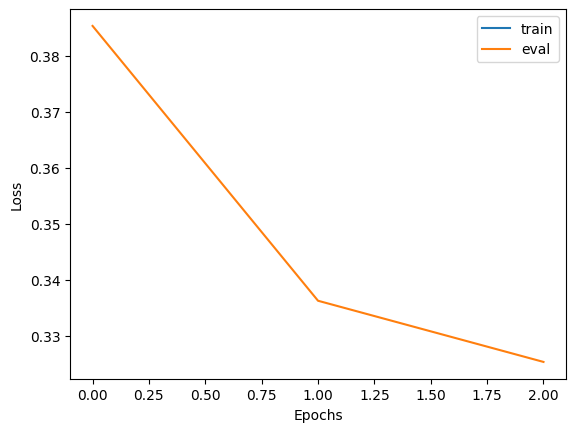

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/bert-base/final/ (stored 0%)
  adding: content/bert-base/final/model.safetensors (deflated 7%)
  adding: content/bert-base/final/vocab.txt (deflated 57%)
  adding: content/bert-base/final/training_args.bin (deflated 51%)
  adding: content/bert-base/final/tokenizer.json (deflated 71%)
  adding: content/bert-base/final/special_tokens_map.json (deflated 42%)
  adding: content/bert-base/final/tokenizer_config.json (deflated 75%)
  adding: content/bert-base/final/config.json (deflated 58%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'bert-base-german-cased')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_bert-base.zip
   creating: /content/bert-base/final/content/bert-base/final/
  inflating: /content/bert-base/final/content/bert-base/final/model.safetensors  
  inflating: /content/bert-base/final/content/bert-base/final/vocab.txt  
  inflating: /content/bert-base/final/content/bert-base/final/training_args.bin  
  inflating: /content/bert-base/final/content/bert-base/final/tokenizer.json  
  inflating: /content/bert-base/final/content/bert-base/final/special_tokens_map.json  
  inflating: /content/bert-base/final/content/bert-base/final/tokenizer_config.json  
  inflating: /content/bert-base/final/content/bert-base/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
example_index = 6

print(test.iloc[example_index]['tokens'])
print(test.iloc[example_index]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[example_index]['tokens'])))

['#', 'RLE', 'DVT', ':', 'Die', 'Antikoagulation', 'wurde', 'aufgrund', 'von', 'Fallenblutungen', 'gestoppt', '.']
['O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'O', 'O', 'O', 'O', 'O', 'O']
[]


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:17<00:00, 75.82it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

    Strength      0.929     0.935     0.932      1778
           O      0.924     0.938     0.931     15970
   Frequency      0.832     0.929     0.878      2535
      Dosage      0.943     0.914     0.929      1771
    Duration      0.827     0.717     0.768       233
        Drug      0.777     0.681     0.726      2557
       Route      0.898     0.792     0.842       701
        Form      0.932     0.897     0.914      1615

    accuracy                          0.903     27160
   macro avg      0.883     0.850     0.865     27160
weighted avg      0.902     0.903     0.902     27160



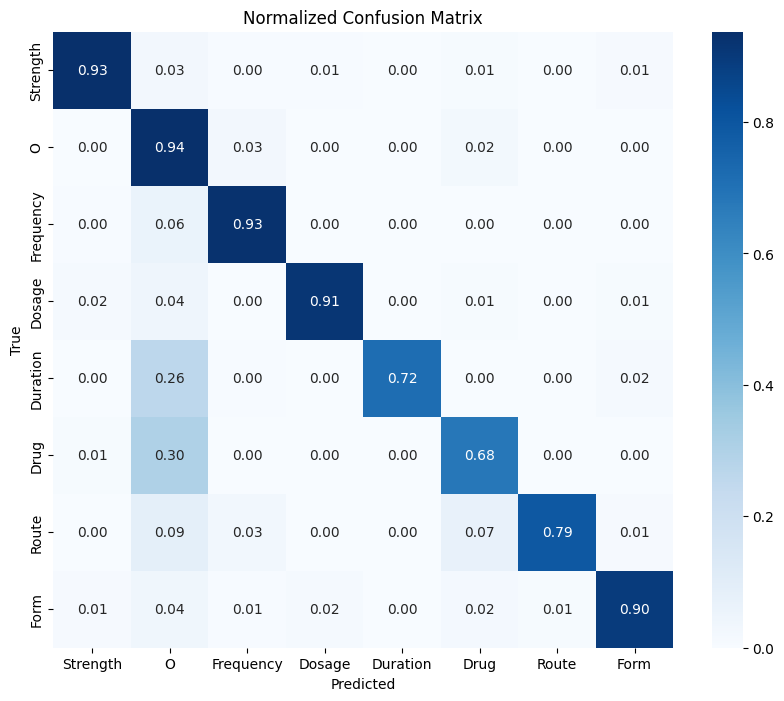

In [ ]:
pipe.print_confusion_matrix()

# RoBERTa

In [ ]:
model_name = "xlm-roberta-base"

##Training

In [ ]:
model = ModelTrainer("FacebookAI/xlm-roberta-base", "FacebookAI/xlm-roberta-base", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7976f9903280>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.423995,0.653540,0.696626,0.674395,0.882361
2,No log,0.340304,0.729566,0.774659,0.751436,0.904077


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


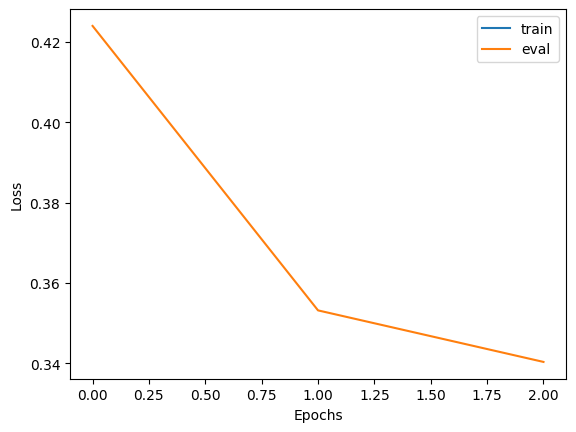

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/xlm-roberta-base/final/ (stored 0%)
  adding: content/xlm-roberta-base/final/model.safetensors (deflated 29%)
  adding: content/xlm-roberta-base/final/training_args.bin (deflated 51%)
  adding: content/xlm-roberta-base/final/tokenizer.json (deflated 76%)
  adding: content/xlm-roberta-base/final/special_tokens_map.json (deflated 52%)
  adding: content/xlm-roberta-base/final/tokenizer_config.json (deflated 76%)
  adding: content/xlm-roberta-base/final/config.json (deflated 58%)
  adding: content/xlm-roberta-base/final/sentencepiece.bpe.model (deflated 49%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'FacebookAI/xlm-roberta-base')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_xlm-roberta-base.zip
   creating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/model.safetensors  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/training_args.bin  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/tokenizer.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/special_tokens_map.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/tokenizer_config.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/config.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/sentencepiece.bpe.model  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['Das', 'Fortschreiten', 'der', 'Leber', '-', 'und', 'portokavalen', 'Lymphadenopathie', '4', 'begann', 'mit', 'Taxol', 'und', 'Avastin', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'O', 'B-Drug', 'I-Drug']
[{'entity_group': 'Drug', 'score': 0.9651694, 'word': 'Taxol', 'start': 77, 'end': 82}, {'entity_group': 'Drug', 'score': 0.8438723, 'word': 'Avastin.', 'start': 87, 'end': 96}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:18<00:00, 70.48it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

        Form      0.918     0.888     0.903      1615
        Drug      0.755     0.718     0.736      2557
    Duration      0.874     0.567     0.688       233
       Route      0.902     0.739     0.813       701
   Frequency      0.813     0.940     0.872      2535
           O      0.932     0.931     0.932     15970
      Dosage      0.939     0.904     0.921      1771
    Strength      0.899     0.942     0.920      1778

    accuracy                          0.900     27160
   macro avg      0.879     0.829     0.848     27160
weighted avg      0.901     0.900     0.899     27160



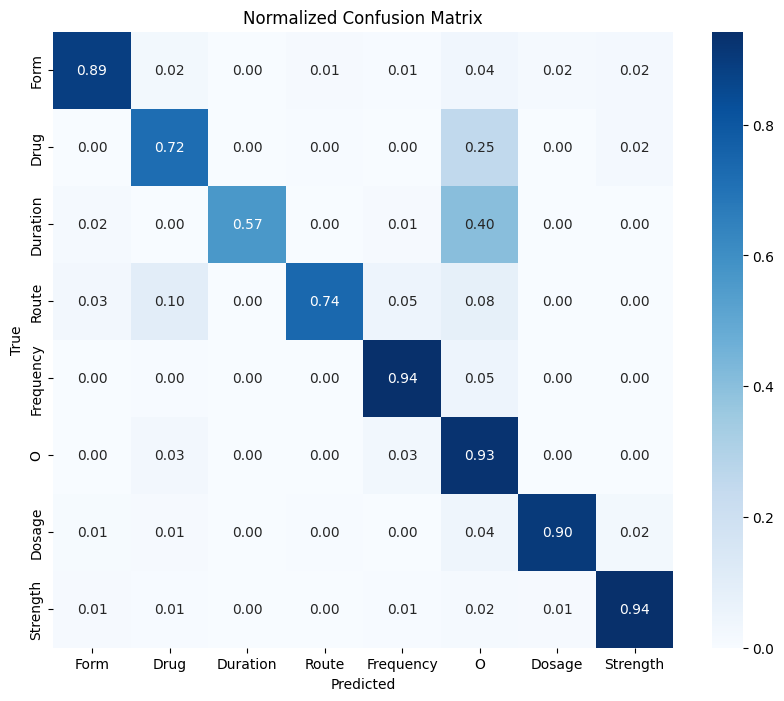

In [ ]:
pipe.print_confusion_matrix()

# ALBERT

In [ ]:
model_name = "albert-base"

##Training

In [ ]:
model = ModelTrainer("ArBert/albert-base-v2-finetuned-ner", "ArBert/albert-base-v2-finetuned-ner", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ArBert/albert-base-v2-finetuned-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7c42710677f0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.429326,0.684171,0.701262,0.692611,0.881202
2,0.498800,0.340634,0.762923,0.771568,0.767222,0.905150


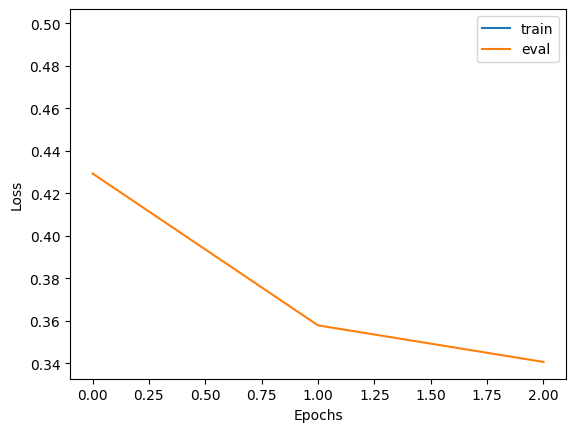

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/albert-base/final/ (stored 0%)
  adding: content/albert-base/final/model.safetensors (deflated 7%)
  adding: content/albert-base/final/training_args.bin (deflated 51%)
  adding: content/albert-base/final/tokenizer.json (deflated 75%)
  adding: content/albert-base/final/special_tokens_map.json (deflated 84%)
  adding: content/albert-base/final/tokenizer_config.json (deflated 74%)
  adding: content/albert-base/final/config.json (deflated 59%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'ArBert/albert-base-v2-finetuned-ner')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_albert-base.zip
   creating: /content/albert-base/final/content/albert-base/final/
  inflating: /content/albert-base/final/content/albert-base/final/model.safetensors  
  inflating: /content/albert-base/final/content/albert-base/final/training_args.bin  
  inflating: /content/albert-base/final/content/albert-base/final/tokenizer.json  
  inflating: /content/albert-base/final/content/albert-base/final/special_tokens_map.json  
  inflating: /content/albert-base/final/content/albert-base/final/tokenizer_config.json  
  inflating: /content/albert-base/final/content/albert-base/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['Das', 'Fortschreiten', 'der', 'Leber', '-', 'und', 'portokavalen', 'Lymphadenopathie', '4', 'begann', 'mit', 'Taxol', 'und', 'Avastin', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'O', 'B-Drug', 'I-Drug']
[{'entity_group': 'Drug', 'score': 0.94530964, 'word': 'taxol', 'start': 77, 'end': 82}, {'entity_group': 'Drug', 'score': 0.8713653, 'word': 'avastin', 'start': 87, 'end': 96}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:24<00:00, 51.73it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

    Strength      0.933     0.924     0.928      1778
           O      0.906     0.933     0.919     15970
       Route      0.873     0.775     0.821       701
        Form      0.924     0.891     0.907      1615
   Frequency      0.763     0.903     0.827      2535
      Dosage      0.958     0.888     0.921      1771
        Drug      0.792     0.624     0.698      2557
    Duration      0.843     0.416     0.557       233

    accuracy                          0.887     27160
   macro avg      0.874     0.794     0.822     27160
weighted avg      0.887     0.887     0.884     27160



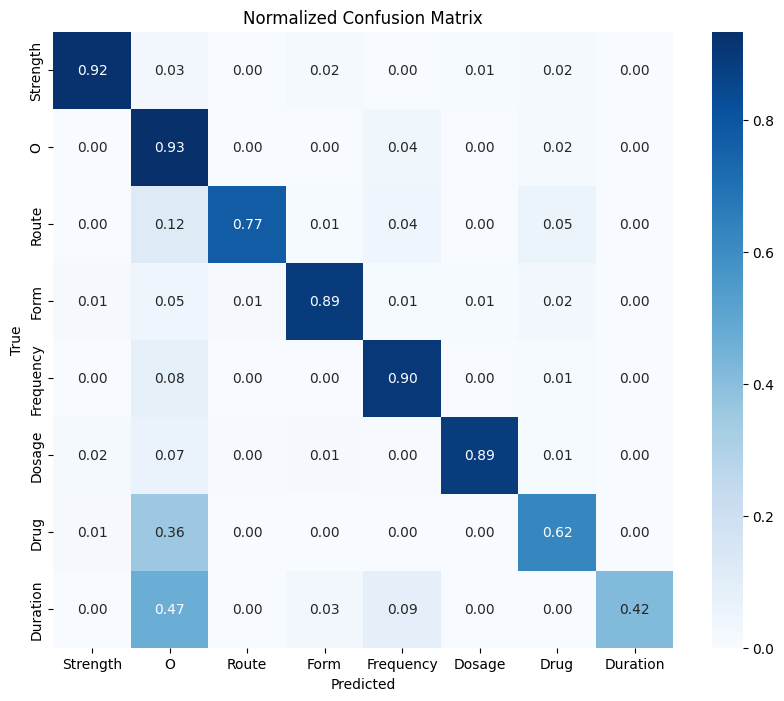

In [ ]:
pipe.print_confusion_matrix()

# GPT-2

In [ ]:
model_name = "gpt2-finetuned"

##Training

In [ ]:
model = ModelTrainer("dbmdz/german-gpt2", "dbmdz/german-gpt2", ids_to_labels, labels_to_ids, prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at dbmdz/german-gpt2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer.json:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7fb13b1a3340>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.677452,0.640990,0.473603,0.544727,0.822017
2,No log,0.511946,0.647142,0.591810,0.618241,0.860043


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


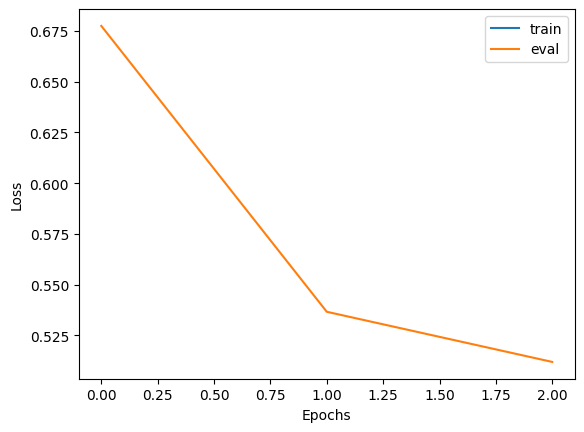

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/gpt2-finetuned/final/ (stored 0%)
  adding: content/gpt2-finetuned/final/model.safetensors (deflated 7%)
  adding: content/gpt2-finetuned/final/training_args.bin (deflated 51%)
  adding: content/gpt2-finetuned/final/vocab.json (deflated 59%)
  adding: content/gpt2-finetuned/final/tokenizer.json (deflated 72%)
  adding: content/gpt2-finetuned/final/merges.txt (deflated 55%)
  adding: content/gpt2-finetuned/final/added_tokens.json (stored 0%)
  adding: content/gpt2-finetuned/final/special_tokens_map.json (deflated 60%)
  adding: content/gpt2-finetuned/final/tokenizer_config.json (deflated 80%)
  adding: content/gpt2-finetuned/final/config.json (deflated 58%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'dbmdz/german-gpt2')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_gpt2-finetuned.zip
   creating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/model.safetensors  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/training_args.bin  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/vocab.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/tokenizer.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/merges.txt  
 extracting: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/added_tokens.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/special_tokens_map.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/tokenizer_config.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


['Das', 'Fortschreiten', 'der', 'Leber', '-', 'und', 'portokavalen', 'Lymphadenopathie', '4', 'begann', 'mit', 'Taxol', 'und', 'Avastin', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'O', 'B-Drug', 'I-Drug']
[{'entity_group': 'Drug', 'score': 0.72585785, 'word': ' Taxol', 'start': 76, 'end': 82}, {'entity_group': 'Drug', 'score': 0.68683654, 'word': ' .', 'start': 94, 'end': 96}]


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:18<00:00, 69.73it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

       Route      0.946     0.628     0.755       701
      Dosage      0.953     0.855     0.901      1771
   Frequency      0.826     0.822     0.824      2535
        Form      0.943     0.788     0.858      1615
        Drug      0.758     0.289     0.418      2557
    Duration      0.909     0.129     0.226       233
           O      0.831     0.959     0.890     15970
    Strength      0.877     0.882     0.879      1778

    accuracy                          0.846     27160
   macro avg      0.880     0.669     0.719     27160
weighted avg      0.845     0.846     0.829     27160



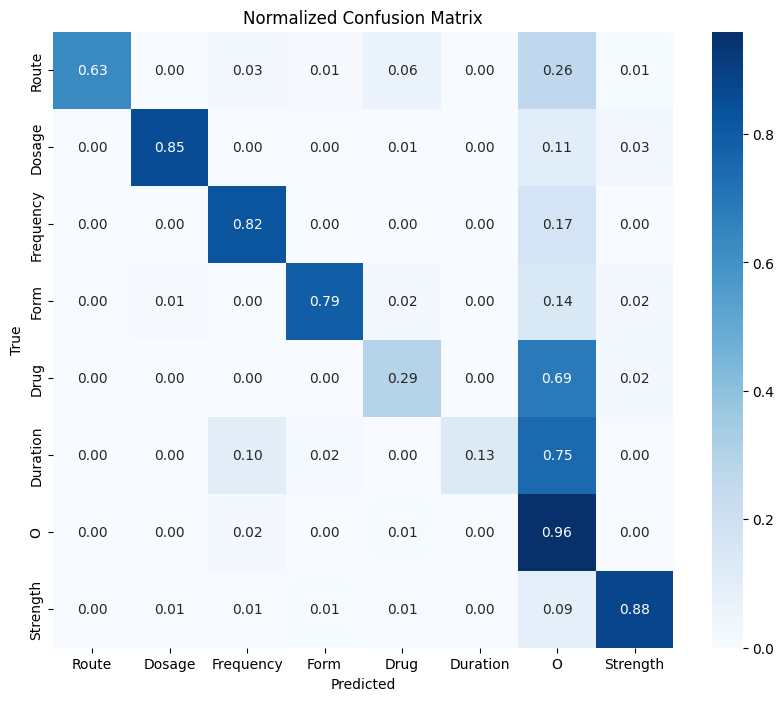

In [ ]:
pipe.print_confusion_matrix()

# GPT-Neo

In [ ]:
model_name = "gpt-neo"

##Training

In [ ]:
model = ModelTrainer("EleutherAI/gpt-neo-125M", "EleutherAI/gpt-neo-125M", ids_to_labels, labels_to_ids, prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForTokenClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x78068a29ece0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.505207,0.631621,0.614216,0.622797,0.862618
2,0.618700,0.433180,0.675641,0.672161,0.673896,0.880172


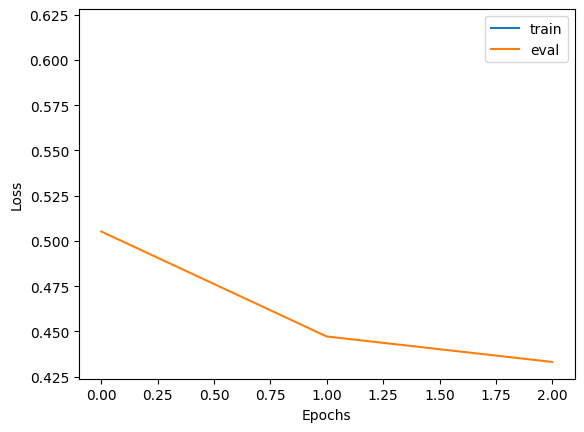

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/gpt-neo/final/ (stored 0%)
  adding: content/gpt-neo/final/model.safetensors (deflated 19%)
  adding: content/gpt-neo/final/training_args.bin (deflated 51%)
  adding: content/gpt-neo/final/vocab.json (deflated 59%)
  adding: content/gpt-neo/final/tokenizer.json (deflated 72%)
  adding: content/gpt-neo/final/merges.txt (deflated 53%)
  adding: content/gpt-neo/final/special_tokens_map.json (deflated 74%)
  adding: content/gpt-neo/final/tokenizer_config.json (deflated 55%)
  adding: content/gpt-neo/final/config.json (deflated 62%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'EleutherAI/gpt-neo-125M')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_gpt-neo.zip
   creating: /content/gpt-neo/final/content/gpt-neo/final/
  inflating: /content/gpt-neo/final/content/gpt-neo/final/model.safetensors  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/training_args.bin  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/vocab.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/tokenizer.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/merges.txt  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/special_tokens_map.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/tokenizer_config.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/config.json  


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['Das', 'Fortschreiten', 'der', 'Leber', '-', 'und', 'portokavalen', 'Lymphadenopathie', '4', 'begann', 'mit', 'Taxol', 'und', 'Avastin', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'O', 'B-Drug', 'I-Drug']
[{'entity_group': 'Drug', 'score': 0.9012881, 'word': ' Taxol', 'start': 76, 'end': 82}, {'entity_group': 'Drug', 'score': 0.7877575, 'word': ' Avastin .', 'start': 86, 'end': 96}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:50<00:00, 25.59it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

    Strength      0.901     0.898     0.900      1778
      Dosage      0.948     0.866     0.905      1771
           O      0.864     0.950     0.905     15970
        Drug      0.743     0.458     0.567      2557
   Frequency      0.829     0.829     0.829      2535
    Duration      0.861     0.451     0.592       233
       Route      0.920     0.703     0.797       701
        Form      0.944     0.845     0.892      1615

    accuracy                          0.867     27160
   macro avg      0.876     0.750     0.798     27160
weighted avg      0.863     0.867     0.859     27160



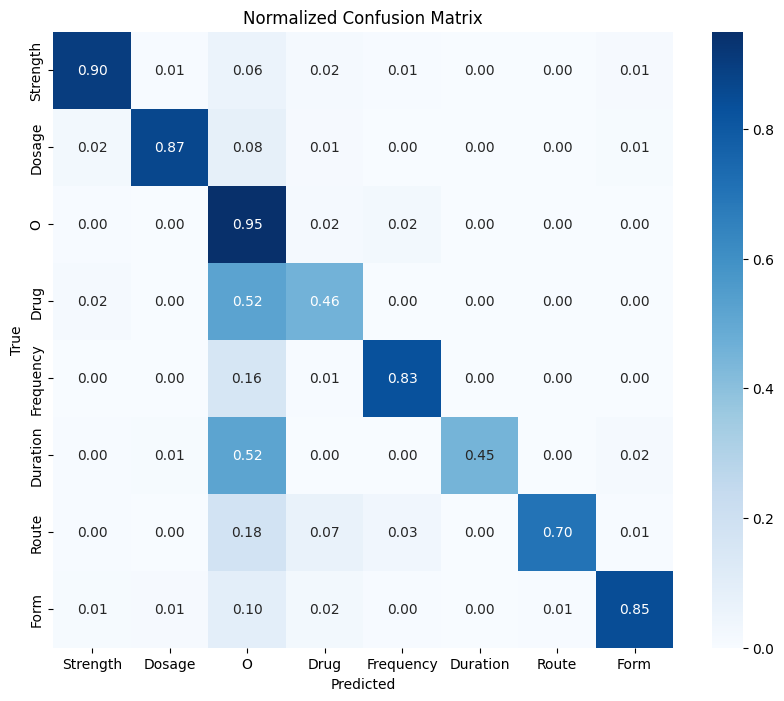

In [ ]:
pipe.print_confusion_matrix()

# T5

In [ ]:
model_name = "google-mt5"

##Training

In [ ]:
model = ModelTrainer("google/mt5-base", "google/mt5-base", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Some weights of MT5ForTokenClassification were not initialized from the model checkpoint at google/mt5-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/usr/local/lib/python3.10/dist-packages/transformers/conver

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7d27bf72a8c0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,2.082730,0.025147,0.016482,0.019913,0.578584
2,2.846100,1.590248,0.158050,0.082668,0.108556,0.654592


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight'].


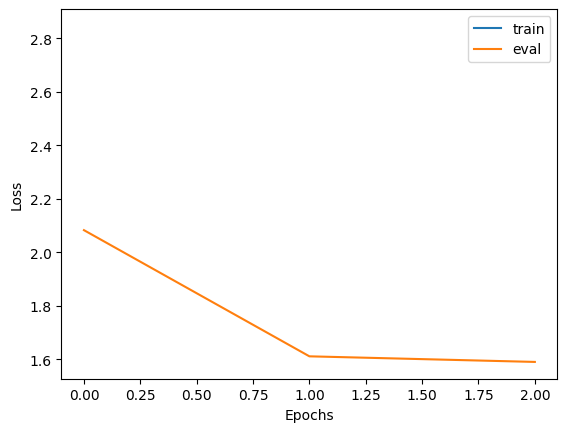

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/google-mt5/final/ (stored 0%)
  adding: content/google-mt5/final/model.safetensors (deflated 36%)
  adding: content/google-mt5/final/training_args.bin (deflated 51%)
  adding: content/google-mt5/final/tokenizer.json (deflated 76%)
  adding: content/google-mt5/final/spiece.model (deflated 46%)
  adding: content/google-mt5/final/special_tokens_map.json (deflated 73%)
  adding: content/google-mt5/final/tokenizer_config.json (deflated 95%)
  adding: content/google-mt5/final/config.json (deflated 57%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'google/mt5-base')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_google-mt5.zip
   creating: /content/google-mt5/final/content/google-mt5/final/
  inflating: /content/google-mt5/final/content/google-mt5/final/model.safetensors  
  inflating: /content/google-mt5/final/content/google-mt5/final/training_args.bin  
  inflating: /content/google-mt5/final/content/google-mt5/final/tokenizer.json  
  inflating: /content/google-mt5/final/content/google-mt5/final/spiece.model  
  inflating: /content/google-mt5/final/content/google-mt5/final/special_tokens_map.json  
  inflating: /content/google-mt5/final/content/google-mt5/final/tokenizer_config.json  
  inflating: /content/google-mt5/final/content/google-mt5/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['Das', 'Fortschreiten', 'der', 'Leber', '-', 'und', 'portokavalen', 'Lymphadenopathie', '4', 'begann', 'mit', 'Taxol', 'und', 'Avastin', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'O', 'B-Drug', 'I-Drug']
[{'entity_group': 'Dosage', 'score': 0.58389723, 'word': 'Leber', 'start': 21, 'end': 27}, {'entity_group': 'Dosage', 'score': 0.9022013, 'word': 'portokavalen', 'start': 33, 'end': 46}, {'entity_group': 'Dosage', 'score': 0.6372905, 'word': 'Lymphadenopathie', 'start': 46, 'end': 63}, {'entity_group': 'Form', 'score': 0.6994827, 'word': 'Taxol', 'start': 76, 'end': 82}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:25<00:00, 49.66it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

      Dosage      0.322     0.682     0.438      1771
           O      0.742     0.564     0.640     15970
    Strength      0.378     0.614     0.468      1778
        Form      0.140     0.491     0.218      1615
       Route      0.247     0.106     0.148       701
   Frequency      0.238     0.066     0.103      2535
    Duration      0.000     0.000     0.000       233
        Drug      0.144     0.090     0.110      2557

    accuracy                          0.463     27160
   macro avg      0.276     0.326     0.266     27160
weighted avg      0.532     0.463     0.473     27160



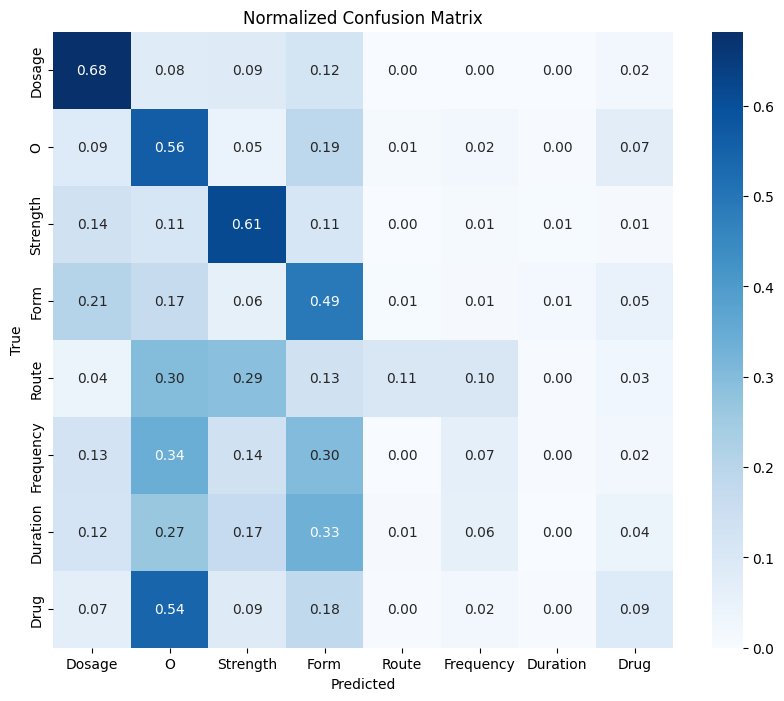

In [ ]:
pipe.print_confusion_matrix()

# XLNet

In [ ]:
model_name = "xlnet-base-cased"

##Training

In [ ]:
model = ModelTrainer("xlnet/xlnet-base-cased", "xlnet/xlnet-base-cased", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7ebaa052f400>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Map:   0%|          | 0/6212 [00:00<?, ? examples/s]

Map:   0%|          | 0/1097 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.402163,0.689573,0.744270,0.715878,0.889399
2,0.337800,0.308654,0.780005,0.811743,0.795558,0.914206


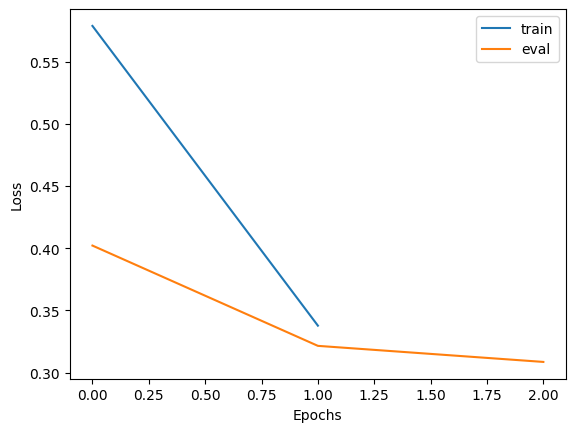

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/xlnet-base-cased/final/ (stored 0%)
  adding: content/xlnet-base-cased/final/model.safetensors (deflated 7%)
  adding: content/xlnet-base-cased/final/training_args.bin (deflated 51%)
  adding: content/xlnet-base-cased/final/tokenizer.json (deflated 75%)
  adding: content/xlnet-base-cased/final/spiece.model (deflated 49%)
  adding: content/xlnet-base-cased/final/special_tokens_map.json (deflated 52%)
  adding: content/xlnet-base-cased/final/tokenizer_config.json (deflated 81%)
  adding: content/xlnet-base-cased/final/config.json (deflated 59%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'xlnet/xlnet-base-cased')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/medic_ner_xlnet-base-cased.zip
   creating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/model.safetensors  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/training_args.bin  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/tokenizer.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/spiece.model  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/special_tokens_map.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/tokenizer_config.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['Das', 'Fortschreiten', 'der', 'Leber', '-', 'und', 'portokavalen', 'Lymphadenopathie', '4', 'begann', 'mit', 'Taxol', 'und', 'Avastin', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'O', 'B-Drug', 'I-Drug']
[{'entity_group': 'Drug', 'score': 0.9641577, 'word': 'Taxol', 'start': 77, 'end': 82}, {'entity_group': 'Drug', 'score': 0.8619971, 'word': 'Avastin.', 'start': 87, 'end': 96}]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 1290/1290 [00:30<00:00, 42.32it/s]


In [ ]:
pipe.print_classification_report()

              precision    recall  f1-score   support

   Frequency      0.832     0.931     0.879      2535
       Route      0.881     0.836     0.858       701
           O      0.936     0.936     0.936     15970
      Dosage      0.951     0.918     0.934      1771
    Duration      0.743     0.695     0.718       233
        Drug      0.792     0.719     0.754      2557
    Strength      0.933     0.936     0.935      1778
        Form      0.910     0.929     0.919      1615

    accuracy                          0.909     27160
   macro avg      0.872     0.863     0.867     27160
weighted avg      0.909     0.909     0.908     27160



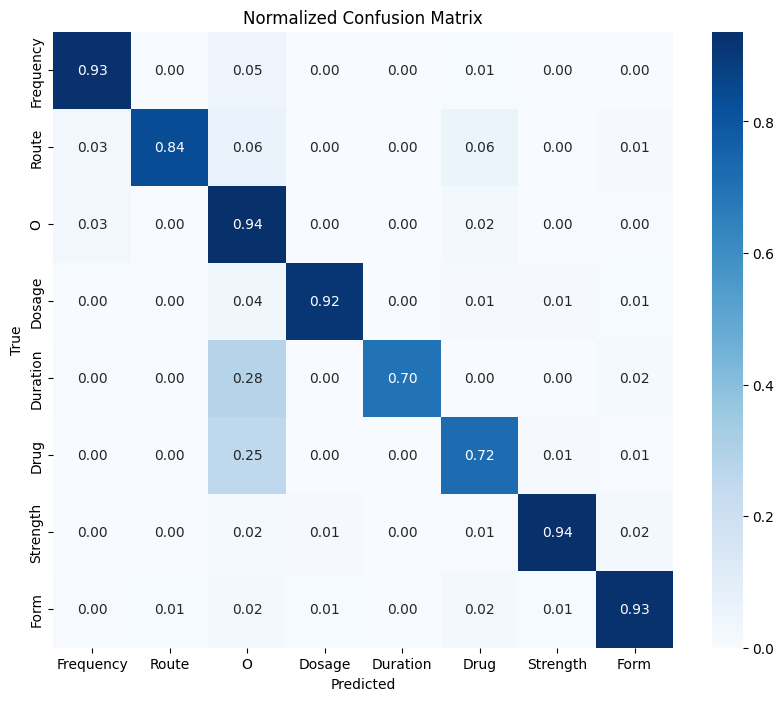

In [ ]:
pipe.print_confusion_matrix()